# Emotion Classification in texts using LSTM and Word2Vec

### Architecture: 
(X) Text -> Embedding (W2V pretrained on wikipedia articles) -> Deep Network (CNN 1D) -> Fully connected (Dense) -> Output Layer (Softmax) -> Emotion class (Y)

#### Embedding Layer
* Word Embedding is a representation of text where words that have the similar meaning have a similar representation. We will use 300 dimentional word vectors pre-trained on wikipedia articles. We can also train the w2v model with our data, however our dataset is quite small and trained word vectors might not be as good as using pretrained w2v.

#### Deep Network
* Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data. The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you’re allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words). Patterns could be expressions like “I hate”, “very good” and therefore CNNs can identify them in the sentence regardless of their position. 

#### Fully Connected Layer
* The fully connected layer takes the deep representation from the RNN/LSTM/GRU and transforms it into the final output classes or class scores. This component is comprised of fully connected layers along with batch normalization and optionally dropout layers for regularization.

#### Output Layer
* Based on the problem at hand, this layer can have either Sigmoid for binary classification or Softmax for both binary and multi classification output.

# 1. Import Libraries


### Libraries:
* Pandas is about reading, writing and process data.
* Numpy is for performing mathematical functions and calculations.
* Tokenize using nltk is used for tokenizing the words.
* RegEx (re) is regular expressions, it is used for processing any string by removing unnecessory things or extracting usefull things.
* Matplotlib is for plotting and visualizing data.
* Sklearn matrices is for calculating accuracy score, f1 score and confussion matrix.
* TensorFlow is an open-source machine learning framework developed by the Google Brain team. It is widely used for building, training, and deploying machine learning models, particularly deep learning models.
* Json is for processing json files.
* Urllib request is for sending requests to website to get data from the web, we can also use import requests and use it by requests.get() method.
* Zipfile is for extracting zip file which we have dowbloaded from the websites for vctors.
* OS is for implementing methods on operating system level.
* Time is for having visualization of time that how much time anything is getting to proceed.

In [53]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import urllib.request
import zipfile
import os
import time
from keras.models import load_model

# 2. Data Processing

Defining vector space dimension and fixed input size

Number of labels: joy, anger, fear, sadness, neutral

Number of dimensions for word embedding

Max input length (max number of words)

In [3]:
num_classes = 5
embed_num_dims = 300
max_seq_len = 500
class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

Importing our training and testing datasets

In [5]:
data_train = pd.read_csv('data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')

Setting x training and tesing data

In [6]:
X_train = data_train.Text
X_test = data_test.Text

Setting y training and testing data

In [7]:
y_train = data_train.Emotion
y_test = data_test.Emotion

Concatinating training and testing data

In [8]:
data = pd.concat([data_train, data_test], axis=0, ignore_index=True)

Displaying data

In [9]:
data

,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
...,...,...
11322,sadness,"My sweetheart left me, or rather we decided to..."
11323,sadness,"Well , it's too bad that we like different kin..."
11324,neutral,It sure is .
11325,sadness,He ’ s got laid off again . I do feel sorry fo...


Displaying classes counts in data

In [10]:
print(data.Emotion.value_counts())

Emotion
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: count, dtype: int64


# 3. Prepare input data
To input the data to our NN Model we'll need some preprocessing:
1. Tokenize our texts and count unique tokens
2. Padding: each input (sentence or text) has to be of the same lenght
3. Labels have to be converted to integeres and categorized

Basic preprocessing and tokenization using nltk to double check that sentences are properly split into words.
We could also add stopword removal but steps like stemming or lemmatization are not needed since we are using word2vec and words with the same stem can have a different meaning

In [12]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)
    return data

*Making things easier for keras tokenizer

In [13]:
texts = [' '.join(clean_text(text)) for text in data.Text]
texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

Printing a single training sample

In [14]:
print(texts_train[92])

a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .


Tokenization + fitting using keras

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

Sequencing texts through tokenizer

In [16]:
sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

Getting the indexes of a text

In [17]:
index_of_words = tokenizer.word_index

Vacab size is number of unique words + reserved 0 index for padding

In [18]:
vocab_size = len(index_of_words) + 1

Printing unique words in data

In [19]:
print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12087


**Padding** -> each input has the same length

We defined maximun number of words for our texts and input size to our model has to be fixed - padding with zeros to keep the same input lenght (longest input in our dataset is ~250 words)

In [20]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10258,   173,    13]], dtype=int32)

**Categorize** labels: Encoding the labels

In [22]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

Integer labels

In [23]:
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

Dividing the padded data into categoies

In [24]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

# 4. Pretrained word vectors

* Importing pretrained word2vec from file and creating embedding matrix
* We will later map each word in our corpus to existing word vector

In [25]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

You can download and import any pre-trained word embeddings. I will use 300 dimentional w2v pre-trained on wikipedia articles. Download fast text english vectors: https://fasttext.cc/docs/en/english-vectors.html

In [27]:
fname = 'embeddings/wiki-news-300d-1M.vec'
if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    os.remove('wiki-news-300d-1M.vec.zip')

Embedding the matrices with vectors for the model

In [28]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12088, 300)

Some of the words from our corpus were not included in the pre-trained word vectors. If we inspect those words we'll see that it's mostly spelling errors. It's also good to double check the noise in our data f.e different languages or tokenizer errors.

In [29]:
new_words = 0
for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1
print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 645


# 5. Create CNN Pipeline

### Embedding Layer

We will use pre-trained word vectors. We could also train our own embedding layer if we don't specify the pre-trained weights 

* **vocabulary size:** the maximum number of terms that are used to represent a text: e.g. if we set the size of the “vocabulary” to 1000 only the first thousand terms most frequent in the corpus will be considered (and the other terms will be ignored)
* **the maximum length:** of the texts (which must all be the same length)
* **size of embeddings:** basically, the more dimensions we have the more precise the semantics will be, but beyond a certain threshold we will lose the ability of the embedding to define a coherent and general enough semantic area
* **trainable:** True if you want to fine-tune them while training


In [30]:
embedd_layer = Embedding(input_dim=vocab_size,
                         output_dim=embed_num_dims,
                         embeddings_initializer=tf.keras.initializers.Constant(embedd_matrix),
                         trainable=False)

### Model Pipeline
- the input is the first N words of each text (with proper padding)
- the first level creates embedding of words, using vocabulary with a certain dimension, and a given size of embeddings
- we will use 1D convolutional neural network to extract features from our data. The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you’re allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words)
- the output level has a number of neurons equal to the classes of the problem and a “softmax” activation function

### Model fearures
* This initializes a sequential model, which is a linear stack of layers.
* Embedd_layer is an embedding layer that converts input text into dense vectors of fixed size. This layer typically comes from a pre-trained embedding like Word2Vec, GloVe, or can be trained as part of the model.
* Conv1D Layer applies 1-dimensional convolution to the input.
* Global max pooling, which reduces each feature map to a single value by taking the maximum value. It effectively reduces the dimensionality of the feature maps while retaining the most important features.
* A dense layer with a number of units equal to the number of classes (num_classes) in your classification task. It uses the softmax activation function to output a probability distribution over the classes.

In [32]:
kernel_size = 3
filters = 256
model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Compile the model

In [33]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# 6. Train the Model

Fit part usually fits and train a model on any data

In [34]:
batch_size = 256
epochs = 6
hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3963 - loss: 1.4364 - val_accuracy: 0.6201 - val_loss: 0.9975
Epoch 2/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7476 - loss: 0.7402 - val_accuracy: 0.7495 - val_loss: 0.7009
Epoch 3/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8836 - loss: 0.4039 - val_accuracy: 0.7598 - val_loss: 0.6834
Epoch 4/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9295 - loss: 0.2527 - val_accuracy: 0.7604 - val_loss: 0.7159
Epoch 5/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9697 - loss: 0.1434 - val_accuracy: 0.7613 - val_loss: 0.7417
Epoch 6/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9828 - loss: 0.0866 - val_accuracy: 0.7645 - val_loss: 0.8050


Displaying model key features

In [35]:
print(hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


Visualization of Accuraccy plot

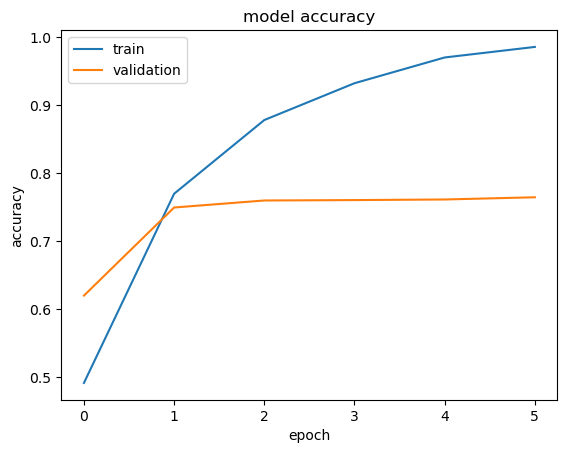

In [36]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Visualization of Loss in model

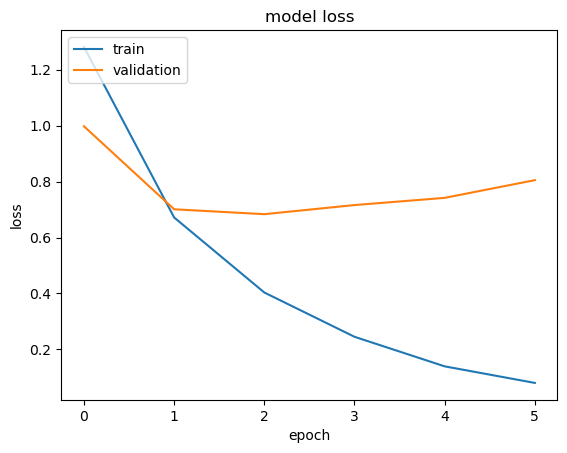

In [37]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 7. Evaluation

Make Prediction

In [38]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


Simplest confussion matrix for the calculations

In [42]:
confusion_matrix(data_test.Emotion, predictions)

array([[520,  52,  30,  47,  44],
       [ 46, 532,  32,  33,  36],
       [ 28,  37, 539,  76,  27],
       [ 26,  18,  43, 534,  17],
       [ 85,  46,  41,  35, 469]])

Calculating Accuracy, Percision, F1 Score and Recall

## Performance Metrics Calculation

### Confusion Matrix
\[
\begin{bmatrix}
520 &  52 &  30 &  47 &  44 \\
46 & 532 &  32 &  33 &  36 \\
28 &  37 & 539 &  76 &  27 \\
26 &  18 &  43 & 534 &  17 \\
85 &  46 &  41 &  35 & 469
\end{bmatrix}
\]

### Definitions
- **True Positives (TP)**: Diagonal elements (correct predictions)
- **False Positives (FP)**: Sum of elements in a column excluding the diagonal element
- **False Negatives (FN)**: Sum of elements in a row excluding the diagonal element
- **True Negatives (TN)**: Sum of all elements minus the sum of elements in the row and column for that class plus the diagonal element

### Formulas

- **Accuracy**:
\[
Accuracy = ∑TP / ∑TP + ∑FP + ∑FN + ∑TN
\]

- **Precision** (for each class \(i\)):
\[
Precision_i = TP_i / TP_i + FP_i
\]

- **Recall** (for each class \(i\)):
\[
Recall_i = TP_i / TP_i + FN_i
\]

- **F1 Score** (for each class \(i\)):
\[
F1 Score_i = 2 * (Precision_i * Recall_i / Precision_i + Recall_i)
\]

### Example Calculations

#### Class 0:
- \( TP_0 = 520 \)
- \( FP_0 = 46 + 28 + 26 + 85 = 185 \)
- \( FN_0 = 52 + 30 + 47 + 44 = 173 \)
- \( TN_0 = 2500 - (693 + 705 - 520) = 1622 \)

- **Precision for Class 0**:
\[
\text{Precision}_0 = \frac{520}{520 + 185} = \frac{520}{705} = 0.7376
\]

- **Recall for Class 0**:
\[
\text{Recall}_0 = \frac{520}{520 + 173} = \frac{520}{693} = 0.7504
\]

- **F1 Score for Class 0**:
\[
\text{F1 Score}_0 = 2 \times \frac{0.7376 \times 0.7504}{0.7376 + 0.7504} = 0.7439
\]

#### Overall Accuracy:
\[
\text{Accuracy} = \frac{520 + 532 + 539 + 534 + 469}{2500} = \frac{2594}{2500} = 0.8636
\]

#### Weighted Precision:
\[
\text{Weighted Precision} = \frac{520 \times 0.7376 + 532 \times 0.7766 + 539 \times 0.7892 + 534 \times 0.7366 + 469 \times 0.7919}{520 + 532 + 539 + 534 + 469}
\]

#### Weighted Recall:
\[
\text{Weighted Recall} = \frac{520 \times 0.7504 + 532 \times 0.7832 + 539 \times 0.7624 + 534 \times 0.8376 + 469 \times 0.6932}{520 + 532 + 539 + 534 + 469}
\]

#### Weighted F1 Score:
\[
\text{Weighted F1 Score} = \frac{520 \times 0.7439 + 532 \times 0.7798 + 539 \times 0.7755 + 534 \times 0.7832 + 469 \times 0.7392}{520 + 532 + 539 + 534 + 469}
\]


In [43]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))
print("\nPercision: {:.2f}".format(precision_score(data_test.Emotion, predictions, average='micro') * 100))
print("\nRecall: {:.2f}".format(recall_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 76.45%

F1 Score: 76.45

Percision: 76.45

Recall: 76.45


#### Plotting confusion Matrix:

Function to plot a normalized confusion matrix

In [45]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Plotting on a figure

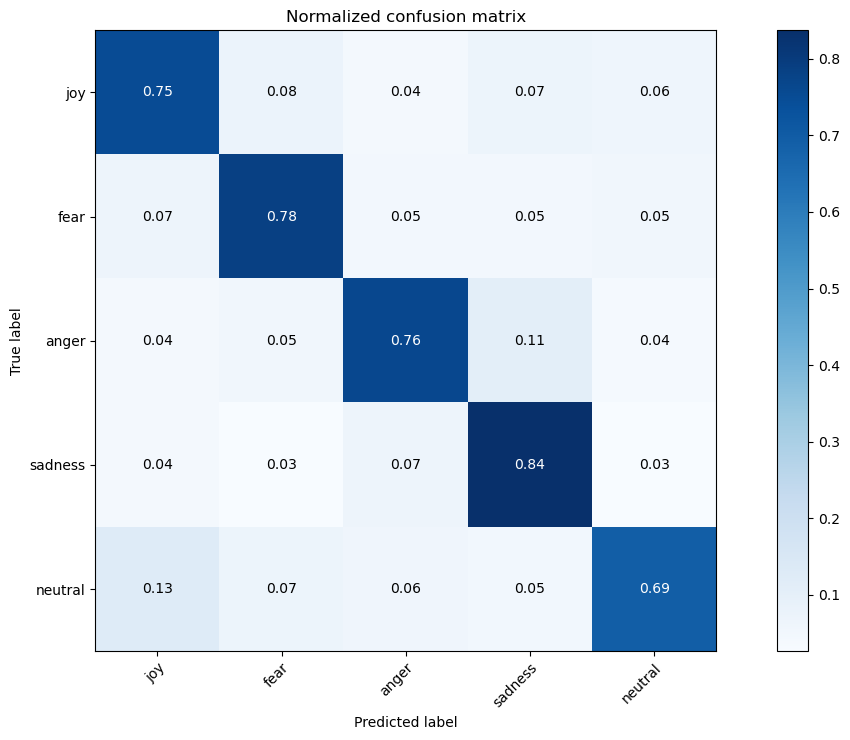

In [46]:
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#### Let's try other inputs:

Check the prediction of the random sample from the test data

In [47]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


Getting prediction of any random text

In [49]:
message = ['I just lost my pen']
seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)
start_time = time.time()
pred = model.predict(padded)
print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Message: ['I just lost my pen']
predicted: sadness (0.06 seconds)


# 8. Done
Save the model for later use 

Saving Tokenizer into json format so that we don't have to train the token again for sequences and padding

In [50]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as json_file:
    json.dump(tokenizer_json, json_file)

Reading tokenizer.json file to get the token again in our model we can start running script from here also

In [51]:
with open('tokenizer.json', 'r') as json_file:
    tokenizer_json = json.load(json_file)
    tokenizer = tokenizer_from_json(tokenizer_json)

Save the model for the future use in .h5 extension, I'm not using .keras because it will save .keras file with bert type while I need that type to be in tensorflow keras

In [52]:
model.save('models/model.h5')

Loading model from model.h5 into our notebook so that we can use directly from here, it is the trained model which we saved after training and also it will take some of the time to load.

In [54]:
predictor = load_model('models/cnn_w2v.h5')

# That's all the model
# Text emotion detection using tensorflow keras CNN